In [1]:
cd /home/c01muya/vae-disentanglement/disentanglement_lib_pl

/home/c01muya/vae-disentanglement/disentanglement_lib_pl


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

import torch, torchvision
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

from vae_experiment import VAEExperiment
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
from notebook_utils import *

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

In [3]:
curr_dev = torch.device("cuda:0")
batch_size = 144
seed = 123

In [4]:
beta = 1.0
z_dim = 2
batch_size = 64
checkpoint_path="../pl-dt-test/3shapesnoisy_beta1/version_0/checkpoints/epoch=99-step=13999.ckpt"


acts_for_threeshapesn, threeshapesn_dataset, model_threeshapesn = load_model_and_data_and_get_activations(
                    dset_name='threeshapesnoisy', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=curr_dev, 
                    activation_with_label=True, seed=123,  batches=None
    )


100%|████████████████████████████████████████████| 140/140 [00:03<00:00, 40.36it/s]


torch.Size([32, 1, 4, 4])


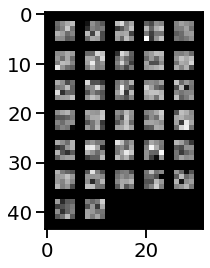

In [22]:

for c, comp in enumerate(model_threeshapesn.model.encoder.main):
    
    if c == 0:
        
        first_layer_kernels = comp.weight.cpu().detach().clone()
        print(first_layer_kernels.size())
        
        # normalize to (0,1) range so that matplotlib can plot them
        first_layer_kernels = first_layer_kernels - first_layer_kernels.min()
        first_layer_kernels = first_layer_kernels / first_layer_kernels.max()
        
        filter_img = torchvision.utils.make_grid(first_layer_kernels, nrow = 5)
        # change ordering since matplotlib requires images to 
        # be (H, W, C)
        plt.imshow(filter_img.permute(1, 2, 0))


In [5]:
beta = 1.0
z_dim = 6
batch_size = 256
checkpoint_path="../pl-dt-test/dsprites_full_beta1/version_0/checkpoints/epoch=51-step=539135.ckpt"


acts_for_dsprites_full, dsprites_full_dataset, model_dsprites_full  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_full', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=curr_dev, 
                    activation_type='without_labels', seed=123,  batches=2000
    )



Loaded 737280 images


 77%|███████████████████████████████▋         | 2000/2592 [00:15<00:04, 129.40it/s]


### How input changes as it goes through the network

In [27]:
dsprites_full_dataloader = DataLoader(dsprites_full_dataset,
                             batch_size=1,
                             shuffle=False,
                             num_workers=8)

result, _ = next(iter(dsprites_full_dataloader))
print(result.shape)
result = result.to(curr_dev)
print("Encoder")
for c, comp in enumerate(model_dsprites_full.model.encoder.main):
    
    print("Operation: ", c, comp)   
    result = comp(result)
    print("Ouput : ", result.shape)
    print()

print("Decoder")
result = result[:, :z_dim]
print(result.shape)
for c, de_comp in enumerate(model_dsprites_full.model.decoder.main):
    print("Operation: ", c, de_comp)
    result = de_comp(result)
    print("Ouput : ", result.shape)
    print()

torch.Size([1, 1, 64, 64])
Encoder
Operation:  0 Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Ouput :  torch.Size([1, 32, 32, 32])

Operation:  1 ReLU(inplace=True)
Ouput :  torch.Size([1, 32, 32, 32])

Operation:  2 Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Ouput :  torch.Size([1, 32, 16, 16])

Operation:  3 ReLU(inplace=True)
Ouput :  torch.Size([1, 32, 16, 16])

Operation:  4 Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Ouput :  torch.Size([1, 64, 8, 8])

Operation:  5 ReLU(inplace=True)
Ouput :  torch.Size([1, 64, 8, 8])

Operation:  6 Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Ouput :  torch.Size([1, 128, 4, 4])

Operation:  7 ReLU(inplace=True)
Ouput :  torch.Size([1, 128, 4, 4])

Operation:  8 Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Ouput :  torch.Size([1, 256, 2, 2])

Operation:  9 ReLU(inplace=True)
Ouput :  torch.Size([1, 256, 2, 2])

Operation:  10 Conv2d(256,

torch.Size([1, 64, 64])
(32, 32, 1)
torch.Size([1, 32, 32, 32])
torch.Size([1, 1, 32, 32])


/home/c01muya/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/skimage/transform/_warps.py:164: UserWarning: Bi-quadratic interpolation behavior has changed due to a bug in the implementation of scikit-image. The new version now serves as a wrapper around SciPy's interpolation functions, which itself is not verified to be a correct implementation. Until skimage's implementation is fixed, we recommend to use bi-linear or bi-cubic interpolation instead.
  out = warp(image, tform, output_shape=output_shape, order=order,


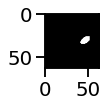

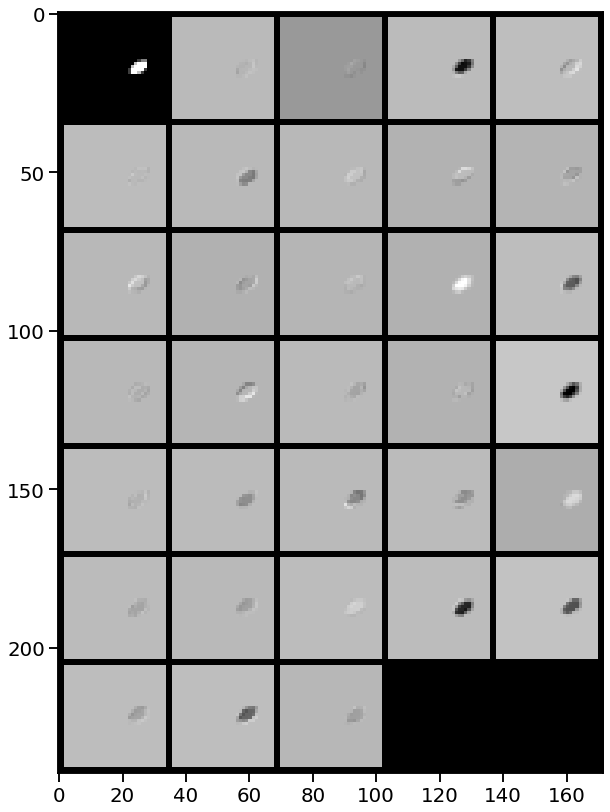

In [7]:
from skimage.transform import resize

anchor_image = dsprites_full_dataset.__getitem__(60000)[0]
print(anchor_image.shape)

anchor_image_resized = resize(anchor_image.permute(1,2,0), (32, 32), order=2)
print(anchor_image_resized.shape)

fig, ax = plt.subplots(figsize=(1,1))
ax.imshow(anchor_image.permute(1,2,0), cmap='gray')

anchor_image = anchor_image.unsqueeze(0)
anchor_image = anchor_image.to(curr_dev)
first_layer_act = model_dsprites_full.model.encoder.main[0](anchor_image)
first_layer_act = first_layer_act.cpu().detach().clone()

print(first_layer_act.shape)
# normalize to (0,1) range so that matplotlib can plot them
first_layer_act = first_layer_act - first_layer_act.min()
first_layer_act = first_layer_act / first_layer_act.max()
first_layer_act = first_layer_act.permute(1,0,2,3)

anchor_as_tensor = transforms.ToTensor()(anchor_image_resized).unsqueeze(0)
print(anchor_as_tensor.shape)
first_layer_act = torch.cat([anchor_as_tensor, first_layer_act], dim = 0)

filter_img = torchvision.utils.make_grid(first_layer_act, nrow = 5)
# change ordering since matplotlib requires images to 
# be (H, W, C)
fig , ax = plt.subplots(figsize=(10,14))
ax.imshow(filter_img.permute(1, 2, 0), cmap='gray')

torch.Size([1, 32, 32, 32])


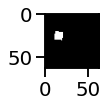

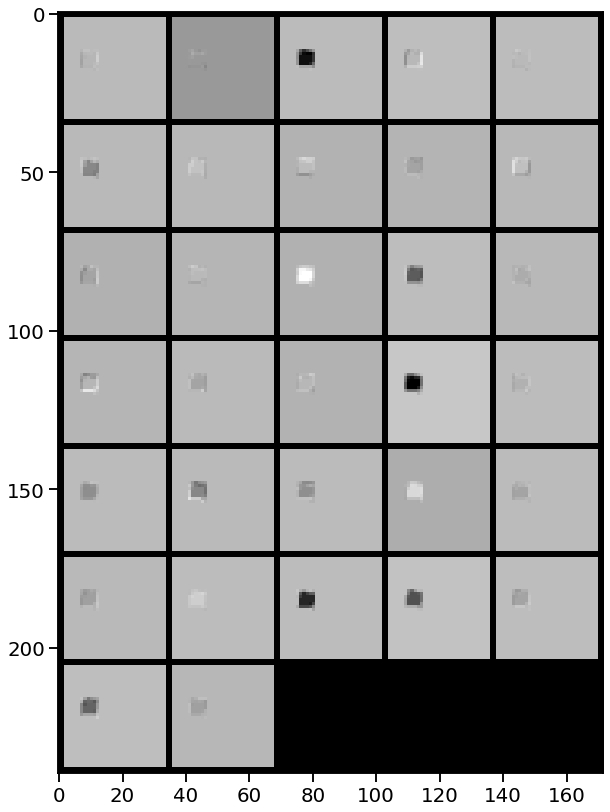

In [53]:
anchor_image = dsprites_full_dataset.__getitem__(50000)[0]
fig, ax = plt.subplots(figsize=(1,1))
ax.imshow(anchor_image.permute(1,2,0), cmap='gray')

anchor_image = anchor_image.unsqueeze(0)
anchor_image = anchor_image.to(curr_dev)
first_layer_act = model_dsprites_full.model.encoder.main[0](anchor_image)
first_layer_act = first_layer_act.cpu().detach().clone()

print(first_layer_act.shape)
# normalize to (0,1) range so that matplotlib can plot them
first_layer_act = first_layer_act - first_layer_act.min()
first_layer_act = first_layer_act / first_layer_act.max()
filter_img = torchvision.utils.make_grid(first_layer_act.permute(1,0,2,3), nrow = 5)
# change ordering since matplotlib requires images to 
# be (H, W, C)
fig , ax = plt.subplots(figsize=(10,14))
ax.imshow(filter_img.permute(1, 2, 0), cmap='gray')

In [24]:
# Ouput :  torch.Size([1, 256, 2, 2])
# Operation:  10 Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
# Ouput :  torch.Size([1, 256, 1, 1])


probe = torch.Tensor([
    [1.,2.],
    [3.,4.]
]).unsqueeze(0).unsqueeze(0)

print(probe.shape)

res = torch.nn.Conv2d(1,2,kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))(probe)

print(res)
print(res.shape)

torch.Size([1, 1, 2, 2])
tensor([[[[-0.4742]],

         [[ 0.9898]]]], grad_fn=<MkldnnConvolutionBackward>)
torch.Size([1, 2, 1, 1])
